In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from helpers import normalize_dataset

In [2]:
training = np.loadtxt("dataset/train.csv",
                 delimiter=",", dtype=str) # load training data
training_labels = training[1:, 0].astype(int) # first column is labels
training_data = normalize_dataset(training[1:, 1:]) # rest of columns are data

In [3]:
classes, class_counts = np.unique(training_labels, return_counts=True)  # get classes and number of samples per class
class_frequencies = dict(zip(classes, class_counts / training_labels.shape[0])) # calculate class frequencies
print("Class Frequencies: ")
for class_type in classes:
    print("Class " + str(class_type) + ": " + str(round(class_frequencies[class_type] * 100, 2)) + "%")

Class Frequencies: 
Class 0: 9.82%
Class 1: 11.15%
Class 2: 9.86%
Class 3: 10.48%
Class 4: 9.69%
Class 5: 8.99%
Class 6: 9.8%
Class 7: 10.51%
Class 8: 9.68%
Class 9: 10.02%


In [4]:
# split data by class
split_data = {cls: training_data[np.argwhere(training_labels == cls), :][:, 0] for cls in classes}

In [5]:
# calculate means and standard deviations for each class
means, std = (np.array(arr) for arr in zip(*[(np.mean(split_data[cls], axis=0), np.std(split_data[cls], axis=0)) for cls in classes]))

In [6]:
# calculate log of class frequencies
log_frequencies = -np.log(np.array([class_frequencies[cls] for cls in classes]))

In [7]:
def predict(input: np.ndarray, input_labels: np.ndarray, alpha: float = 0.0151):
    '''
    Predicts the class of a given input
    @param input N x TOTAL_PIXELS
    @param input_labels N-length 1D array of labels
    @param alpha hyperparameter for smoothing
    
    @return (dict of class -> accuracy of class, average accuracy of predictions)
    '''
    predictions = []
    # for each sample
    for sample_index in range(input.shape[0]):
        exponent = -(((input[sample_index] - means) ** 2) / (2 * (std ** 2 + alpha)))
        log_prob = np.sum(exponent - np.log(np.sqrt(2 * math.pi * (std ** 2 + alpha))), axis=1) + log_frequencies
        # per class log probability of sample
        sample_predictions = dict(zip(classes, log_prob))
        # get class with highest probability
        max_val = -np.inf
        prediction = None
        for cls in classes:
            value = sample_predictions[cls]
            if value > max_val:
                prediction = cls
                max_val = value
        predictions.append(prediction)
    # calculate accuracy
    class_accuracies = {}
    for cls in classes:
        label_mask = input_labels == cls
        class_accuracies[cls] = np.sum(label_mask[np.array(predictions) == cls]) / np.sum(label_mask)
    return class_accuracies, np.mean(predictions == input_labels)

In [8]:
# predict on training data
training_class_accuracies, training_overall_accuracy = predict(training_data, training_labels)
print("Training Data Accuracy: ")
for cls in classes:
    print("Class " + str(cls) + ": " + str(round(training_class_accuracies[cls] * 100, 2)) + "%")
print("Overall Accuracy: " + str(round(training_overall_accuracy * 100, 2)) + "%")

Training Data Accuracy: 
Class 0: 89.76%
Class 1: 96.58%
Class 2: 75.23%
Class 3: 75.66%
Class 4: 65.76%
Class 5: 62.7%
Class 6: 91.84%
Class 7: 81.39%
Class 8: 73.56%
Class 9: 86.55%
Overall Accuracy: 80.29%


In [9]:
testing = np.loadtxt("dataset/test.csv",
                 delimiter=",", dtype=str) # load test data
testing_labels = testing[1:, 0].astype(int) # first column is labels
testing_data = normalize_dataset(testing[1:, 1:]) # rest of columns are data

In [10]:
# predict on testing data
testing_class_accuracies, testing_overall_accuracy = predict(testing_data, testing_labels)
print("Testing Data Accuracy: ")
for cls in classes:
    print("Class " + str(cls) + ": " + str(round(testing_class_accuracies[cls] * 100, 2)) + "%")
print("Overall Accuracy: " + str(round(testing_overall_accuracy * 100, 2)) + "%")

Testing Data Accuracy: 
Class 0: 90.5%
Class 1: 96.86%
Class 2: 77.44%
Class 3: 76.49%
Class 4: 67.87%
Class 5: 60.16%
Class 6: 91.28%
Class 7: 81.91%
Class 8: 75.72%
Class 9: 87.14%
Overall Accuracy: 80.9%


Best accuracy: 80.9
Best alpha: 0.015099999999999978


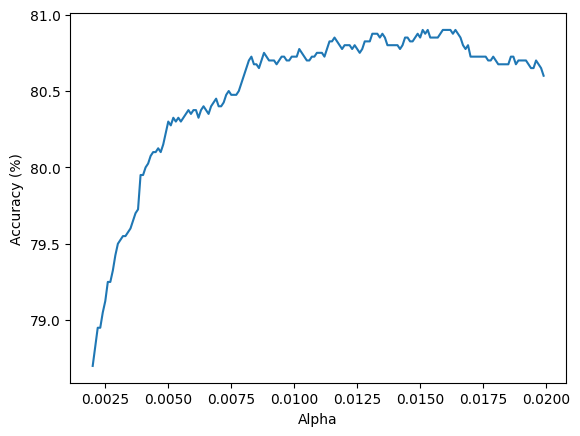

In [11]:
# fine-tuning alpha
start_alpha = 0.002
step = 1e-4
end_alpha = 0.02
alphas = np.arange(start_alpha, end_alpha, step)
accuracies = []
best_accuracy = -np.inf
best_alpha = None
for alpha in alphas:
    _, accuracy = predict(testing_data, testing_labels, alpha)
    accuracy *= 100
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_alpha = alpha
        
print("Best accuracy: " + str(best_accuracy))
print("Best alpha: " + str(best_alpha))

plt.xlabel("Alpha")
plt.ylabel("Accuracy (%)")
plt.plot(alphas, accuracies)